In [144]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import numpyro
import numpyro.distributions as dist
import blackjax

In [145]:
rng_key = jax.random.PRNGKey(44)
k1, k2, k3 = jax.random.split(rng_key, 3)

In [146]:
# base_dist = dist.Normal(0, 1).expand(jnp.array([2]))
# x = base_dist.sample(k1, (1000,))[:, 0]
# y = base_dist.sample(k1, (1000,))[:, 1]
with numpyro.handlers.seed(rng_seed=7):
    y = numpyro.sample("y", dist.Normal().expand([50]))
    x = numpyro.sample("x", dist.Normal().expand([50]))
    x = (x - jnp.mean(x)) / jnp.std(x)
    y = (y - jnp.mean(y)) / jnp.std(y)

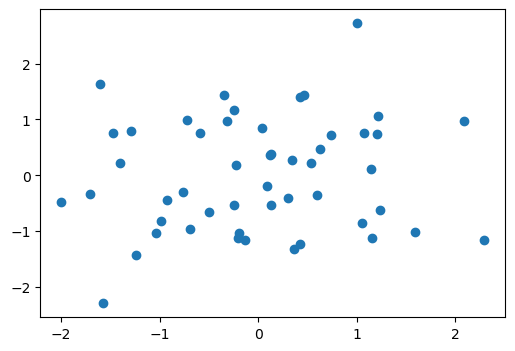

In [147]:
plt.figure(figsize=(6, 4))
plt.scatter(x, y);

In [ ]:
x = jnp.arange(-3, 3, 0.1)
y = jnp.arange(-3, 3, 0.1)
X, Y = jnp.meshgrid(x, y)
Z = jnp.dstack(X, Y)

In [182]:
def target_density(q, a=0, b=1, k=0, d=1):
    
    # q = list of params of d-dimension
    mu_y = q[0]
    mu_x = q[1]

    # priors
    log_probs_mu_x = dist.Normal(loc=a, scale=b).log_prob(mu_x)
    log_probs_mu_y = dist.Normal(loc=k, scale=d).log_prob(mu_y)

    # likelihood
    log_prob_y = jnp.sum(dist.Normal(loc=mu_y, scale=1).log_prob(y))
    log_prob_x = jnp.sum(dist.Normal(loc=mu_x, scale=1).log_prob(x))

    # posterior
    posterior = log_prob_x + log_prob_y + log_probs_mu_x + log_probs_mu_y

    return -posterior

In [183]:
grad_target_density = jax.grad(target_density)

In [294]:
def HMC2(U, grad_U, epsilon, L, current_q, rng):
    q = current_q
    # random flick - p is momentum
    p = dist.Normal(0, 1).sample(jax.random.fold_in(rng, 0), (q.shape[0],))
    current_p = p
    # Make a half step for momentum at the beginning
    p = p - epsilon * grad_U(q) / 2
    # initialize bookkeeping - saves trajectory
    qtraj = jnp.full((L + 1, q.shape[0]), jnp.nan)
    ptraj = qtraj
    intra_proposal_energy = jnp.full((L + 1, 1), jnp.nan)
    qtraj = qtraj.at[0].set(current_q)
    ptraj = ptraj.at[0].set(p)
    intra_proposal_energy.at[0].set(0)

    print("---- start of trajectory ----")
    print(f"p = {p}, q = {q}")
    
    intra = []
    # Alternate full steps for position and momentum
    print(f"---- intra-trajectory points ----")
    for i in range(L):
        runif = dist.Uniform().sample(jax.random.fold_in(rng, 1))
        q = q + epsilon * p  # Full step for the position
        # Make a full step for the momentum, except at end of trajectory
        if i != (L - 1):
            p = p - epsilon * grad_U(q)
            ptraj = ptraj.at[i + 1].set(p)

        qtraj = qtraj.at[i + 1].set(q)

        intra_proposal_p = jnp.sum(p ** 2) / 2
        intra_proposal_q = U(q)
        intra.append(intra_proposal_q)
        #intra_proposal_energy.at[i + 1].set(intra_proposal_q)
        #print(f"intra-traj. energy: q = {intra_proposal_q}")


        print(f"p = {p}, q = {q}, intra-q-energy = {intra_proposal_q}")

    multinomial_probs = jax.nn.softmax(jnp.array(intra))
    #print(normalized_energy)
    print("---- multinomial probs. ----")
    print(multinomial_probs)

    # Make a half step for momentum at the end
    p = p - epsilon * grad_U(q) / 2
    ptraj = ptraj.at[L].set(p)
    # Negate momentum at end of trajectory to make the proposal symmetric
    p = -p
    # Evaluate potential and kinetic energies at start and end of trajectory
    current_U = U(current_q)
    current_K = jnp.sum(current_p ** 2) / 2
    proposed_U = U(q)
    proposed_K = jnp.sum(p ** 2) / 2

    print("---- end of trajectory ----")
    print(f"p = {p}, q = {q}")

    print("---- end of traj. kinetic and potential energies ----")
    print(f"p = {proposed_K}, q = {proposed_U}")


    # Accept or reject the state at end of trajectory, returning either
    # the position at the end of the trajectory or the initial position
    accept = 0
    runif = dist.Uniform().sample(jax.random.fold_in(rng, 1))
    if runif < jnp.exp(current_U - proposed_U + current_K - proposed_K):
        new_q = q  # accept
        print("** proposed new q **")
        print(f"q = {new_q}")
        accept = 1
    else:
        new_q = current_q  # reject
    return {
        "q": new_q,
        "traj": qtraj,
        "ptraj": ptraj,
        "accept": accept,
        "dH": proposed_U + proposed_K - (current_U + current_K),
    }

In [295]:
Q = {}
Q["q"] = jnp.array([-0.1, 0.2])
pr = 0.31
step = 0.03
L = 9  # 0.03/28 for U-turns --- 11 for working example
n_samples = 1

for i in range(n_samples):
    Q = HMC2(
        target_density, 
        grad_target_density, 
        step, 
        L, 
        Q["q"], 
        jax.random.fold_in(jax.random.PRNGKey(0), i)
    )

---- start of trajectory ----
p = [ 1.0002687 -1.3884375], q = [-0.1  0.2]
---- intra-trajectory points ----
p = [ 1.1073564 -1.6307082], q = [-0.06999194  0.15834688], intra-q-energy = 144.4960174560547
p = [ 1.1636164 -1.7981294], q = [-0.03677125  0.10942563], intra-q-energy = 144.07156372070312
p = [ 1.1664665 -1.8830165], q = [-0.00186275  0.05548175], intra-q-energy = 143.81031799316406
p = [ 1.1157757 -1.8814731], q = [ 0.03313124 -0.00100874], intra-q-energy = 143.759765625
p = [ 1.0138708 -1.79357  ], q = [ 0.06660451 -0.05745293], intra-q-energy = 143.9290313720703
p = [ 0.8654293 -1.6233422], q = [ 0.09702063 -0.11126003], intra-q-energy = 144.2874298095703
p = [ 0.6772645 -1.378603 ], q = [ 0.12298352 -0.15996028], intra-q-energy = 144.7698974609375
p = [ 0.4580133 -1.0705858], q = [ 0.14330146 -0.20131837], intra-q-energy = 145.2888641357422
p = [ 0.4580133 -1.0705858], q = [ 0.15704186 -0.23343594], intra-q-energy = 145.7501678466797
[144.49602 144.07156 143.81032 143.759

## Blackjax

In [87]:
initial_pos = jnp.array([1., 1.])
rmh = blackjax.rmh(target_density, sigma=jnp.array(1.))
initial_state = rmh.init(initial_pos)

In [74]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [143]:
rng_key = jax.random.PRNGKey(314)
_, rng_key = jax.random.split(rng_key)
states = inference_loop(rng_key, rmh.step, initial_state, 100)

ValueError: 

In [135]:
# HMC
step_size = 1e-5
inverse_mass_matrix = jnp.array([1., 1.])
hmc = blackjax.hmc(target_density, step_size, inverse_mass_matrix, 1e-2)

# initialize the state
initial_pos = jnp.array([0., 0.])
state = hmc.init(initial_pos)

# iterate
samples = []
step = jax.jit(hmc.step)
for _ in range(1000):
    _, rng_key = jax.random.split(rng_key)
    state, _ = step(rng_key, state)
    samples.append(state.position)

samples = jnp.array(samples)

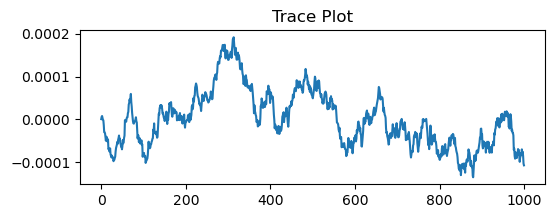

In [140]:
sample_len = jnp.arange(0, 1000)
plt.figure(figsize=(6, 2))
plt.plot(sample_len, samples[:, 0])
plt.title('Trace Plot');

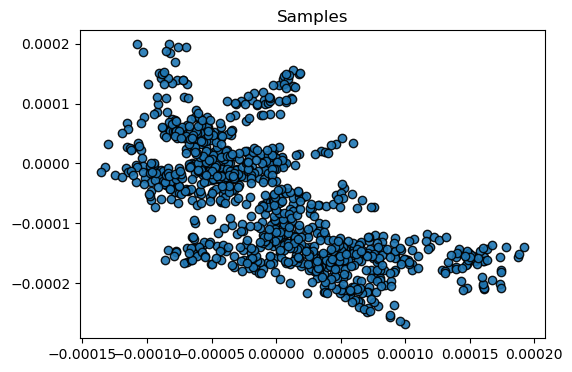

In [141]:
plt.figure(figsize=(6, 4))
plt.scatter(samples[:, 0], samples[:, 1], edgecolors='black', alpha=0.9)
plt.title('Samples');